In [99]:
from __future__ import division
from dolfin import *
import math
import numpy as np
import sys
import os


#!sudo pip2.7 install easydict
from easydict import EasyDict as edict

%matplotlib inline

In [100]:
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [101]:
print(has_linear_algebra_backend("PETSc"), has_linear_algebra_backend("Tpetra"))
print(has_krylov_solver_preconditioner("amg"), has_krylov_solver_method("minres"))

(True, False)
(True, True)


In [102]:
############
#Model letter and number, output directory setup
############


#Model letter identifier default
Model = "T"

#Model number identifier default:
ModNum = 0

#Any isolated letter / integer command line args are interpreted as Model/ModelNum

if len(sys.argv) == 1:
    ModNum = ModNum 
elif sys.argv[1] == '-f': #
    ModNum = ModNum 
else:
    for farg in sys.argv[1:]:
        if not '=' in farg: #then Assume it's a not a paramter argument
            try:
                ModNum = int(farg) #try to convert everingthing to a float, else remains string
            except ValueError:
                Model  = farg


outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" 
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '.dat'

if rank==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)

        
comm.Barrier() #Barrier here so no procs run the check in the next cell too early

In [103]:
###########
#Parameter / settings dictionaries get saved&loaded using pickle
###########
 
dp = edict({}) #dimensional parameters
sf = edict({}) #scaling factors
ndp = edict({}) #dimensionless paramters
md = edict({}) #model paramters, flags etc
#od = edict({}) #output frequencies
 


dict_list = [dp, sf, ndp, md]
dict_names = ['dp.pkl', 'sf.pkl', 'ndp.pkl', 'md.pkl']



###########
#Store the physical parameters, scale factors and dimensionless pramters in easyDicts
#dp : dimensional paramters
###########


dp = edict({#'LS':10*1e3, #Scaling Length scale
            'LS':30*1e3, #Scaling Length scale
            #'asthenosphere': (0.*1e3)/4, #level from bottom of model,
            'asthenosphere': (30*1e3)/4, #level from bottom of model, 
            'eta0':1e21,
            'eta1':1e23,
            'eta2':1e20,
            #'U0':0.006/(3600*24*365),  #m/s kaus
            #'U0':0.0025/(3600*24*365),  #m/s speigelman et al
            'U0':0.0125/(3600*24*365),  #m/s speigelman et al
            'rho': 2700., #kg/m3
            'g':9.81,
            #'cohesion':40e6, #kaus
            'cohesion':100e6, #speigelman et al
            'fa':25.        #friction angle degrees
        
            })


dp.notchWidth = dp.LS/12.

#Modelling and Physics switches
#md : model dictionary

md = edict({'refineMesh':False,
            'stickyAir':False,
            'aspectRatio':4.,
            'res':64,
            'ppc':25,
            'tol':1e-3,
            'maxIts':150,
            })


###########
#If command line args are given, overwrite
#Note that this assumes that params as commans line args/
#only append to the 'dimensional' and 'model' dictionary (not the non-dimensional)
###########    


###########
#If extra arguments are provided to the script" eg:
### >>> uw.py 2 dp.arg1=1 dp.arg2=foo dp.arg3=3.0
###
###This would assign ModNum = 2, all other values go into the dp dictionary, under key names provided
###
###Two operators are searched for, = & *=
###
###If =, parameter is re-assigned to givn value
###If *=, parameter is multipled by given value
###
### >>> uw.py 2 dp.arg1=1 dp.arg2=foo dp.arg3*=3.0
###########

for farg in sys.argv[1:]:
    try:
        (dicitem,val) = farg.split("=") #Split on equals operator
        (dic,arg) = dicitem.split(".") #colon notation
        if '*=' in farg:
            (dicitem,val) = farg.split("*=") #If in-place multiplication, split on '*='
            (dic,arg) = dicitem.split(".")
            
        if val == 'True': 
            val = True
        elif val == 'False':     #First check if args are boolean
            val = False
        else:
            try:
                val = float(val) #next try to convert  to a float,
            except ValueError:
                pass             #otherwise leave as string
        #Update the dictionary
        if farg.startswith('dp'):
            if '*=' in farg:
                dp[arg] = dp[arg]*val #multiply parameter by given factor
            else:
                dp[arg] = val    #or reassign parameter by given value
        if farg.startswith('md'):
            if '*=' in farg:
                md[arg] = md[arg]*val #multiply parameter by given factor
            else:
                md[arg] = val    #or reassign parameter by given value
                
    except:
        pass
            

comm.barrier()

In [104]:
#Only build these guys first time around, otherwise the read from checkpoints
#Important because some of these params (like SZ location) may change during model evolution


#sf : scaling factors
#ndp : non dimensional paramters



sf = edict({'stress':(dp.eta0*dp.U0)/dp.LS,
            'vel':dp.U0,
            'density':dp.LS**3,
            'g':dp.g,
            'rho':(dp.eta0*dp.U0)/(dp.LS**2*dp.g)
           })

#dimensionless parameters

ndp = edict({'U':dp.U0/sf.vel,
             'asthenosphere':dp.asthenosphere/dp.LS,
             'eta1':dp.eta1/dp.eta0,
             'eta2':dp.eta2/dp.eta0,
             'cohesion':dp.cohesion/sf.stress,
             'fa':math.tan((math.pi/180.)*dp.fa), #convert friction angle to coefficient,
             'g': dp.g/sf.g,
             'rho':dp.rho/sf.rho,
             'notchWidth':dp.notchWidth/dp.LS
            
            })

In [105]:
# =============================================================================
# MESH
# =============================================================================

width, height = 4, 1 # domain width and height
# option "crossed" stands for crossed diagonals (number of elements=XDIV*ZDIV*4)
mesh = RectangleMesh(Point(-2, 0), Point(2.0, 1.0), md.res*4, md.res, "crossed")
cell = triangle
norm = FacetNormal(mesh) # definition of an outer normal

ez = Constant((0, -1)) #gravity vector



In [106]:
#from mshr import *
#domain = Rectangle(dolfin.Point(-2., 0.), dolfin.Point(2., 1.))
#mesh = generate_mesh(domain,120)
#cell = triangle
#norm = FacetNormal(mesh) # definition of an outer normal

#ez = Constant((0, -1)) #gravity vector

In [107]:
#Try loading the refined mesh from speigelman

#mesh = Mesh("../plasticitymodels/mesh/compression_mesh_rounded_refine.xml.gz")
#coords = mesh.coordinates()
#coords[:,1] += 1.
#cell = triangle
#norm = FacetNormal(mesh) # definition of an outer normal

#ez = Constant((0, -1)) #gravity vector

In [108]:
# =============================================================================
# Mesh refine
# =============================================================================


if md.refineMesh:

    for i in [4.,2.,1.5]:
        center = Point(0.0, ndp.asthenosphere)
        radius = ndp.notchWidth * i

        # Mark cells for refinement
        markers = MeshFunction("bool", mesh, mesh.topology().dim())
        markers.set_all(False)
        for cell in cells(mesh):
            if (cell.midpoint().distance(center) < radius) and (cell.midpoint().y() > ndp.asthenosphere):
                markers[cell.index()] = True

        num_refinements = 1

        for i in range(num_refinements):

            # Refine mesh
            mesh = refine(mesh, markers)


In [109]:
File('mesh.pvd') << mesh

In [110]:
# =============================================================================
# Define function spaces
# =============================================================================

# Taylor-Hood elements: linear Lagrange elements for pressure
# and quadratic Lagrange elements for velocity


V = VectorElement("Lagrange", mesh.ufl_cell(), 2)
P = FiniteElement("Lagrange", mesh.ufl_cell(), 1)

TH = V * P
W = FunctionSpace(mesh, TH)

In [111]:
# Define variational problem

(u , p) = TrialFunctions(W)


(v , q)= TestFunctions(W)



In [112]:
# =============================================================================
# INITIAL CONDITIONS - & Material distribution
# =============================================================================
u_init = Expression(("0", "0","0"), degree=2) # zero


density=Constant(ndp.rho)


tol = 1e-14

eta_1 = ndp.eta1
eta_2 = ndp.eta2





In [113]:
#Fast but opaque C++ string, 
#eta = Expression('x[1] < 1./16 + tol && x[0] < 1./16 && x[0] > -1./16 ? eta_1 : eta_2', degree=0,
#               tol=tol, eta_1=eta_1, eta_2=eta_2)


class Eta(Expression):
    def set_eta_values(self, eta_1, eta_2):
        self.eta_1, self.eta_2 = eta_1, eta_2
    def eval(self, value, x):
        "Set value[0] to value at point x"
        
        #circle1 = np.dot(x[0] - cCentre[0], x[0] - cCentre[0]) +   np.dot( x[1] - cCentre[1], x[1] - cCentre[1])
        mu = ndp.notchWidth
        sig =  0.1*ndp.notchWidth
        gausFn1 = ndp.notchWidth*math.exp(-1.*(x[0] - mu)**2/(2 * sig**2)) + ndp.asthenosphere

        gausFn2 = ndp.notchWidth*math.exp(-1.*(x[0] + mu)**2/(2 * sig**2)) + ndp.asthenosphere
        
        if (x[1] <= ndp.asthenosphere):
            value[0] = self.eta_2
        
        elif (x[1] < ndp.asthenosphere + ndp.notchWidth) and (x[0] < ndp.notchWidth) and (x[0] > -1.*ndp.notchWidth):
            value[0] = self.eta_2
        
        #elif x[1] < gausFn1:
        #    value[0] = self.eta_2
        #elif x[1] < gausFn2:
        #    value[0] = self.eta_2

        else:
            value[0] = self.eta_1
    
            
            
# Initialize Eta - viscosity
etaExpr = Eta(degree=1)
etaExpr.set_eta_values(ndp.eta1, eta_2)
etaExpr.eta_1, etaExpr.eta_2

(99.99999999999999, 0.1)

In [114]:
# Initialize Eta - viscosity
etaExpr = Eta(degree=1)
etaExpr.set_eta_values(ndp.eta1, eta_2)
etaExpr.eta_1, etaExpr.eta_2

(99.99999999999999, 0.1)

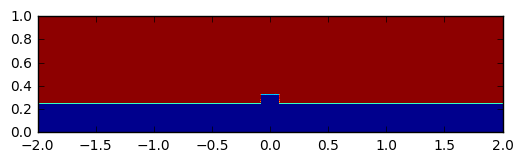

In [115]:
# =============================================================================
# Plotting expressions
# =============================================================================


X = FunctionSpace(mesh, P)

f = Function(X)
f.interpolate(etaExpr)
plot(f )

In [116]:
File('visc.pvd') << f

In [117]:
#%pylab inline

#coords = mesh.coordinates()
#triplot(coords[:,0], coords[:,1], triangles=mesh.cells())
#print mesh.num_cells()

In [118]:
# =============================================================================
# BOUNDARY CONDITIONS
# =============================================================================

# Define boundaries
def left(x):
    return near(x[0], -2)

def right(x):
    return near(x[0], 2)


def bottom(x):
    return near(x[1], 0)

def top(x):
    return near(x[1], 1)




noslip = Constant((0, 0))
freeslip = Constant(0)
leftBC = Constant((1.0, 0))
rightBC = Constant((-1.0, 0))

#W.sub(1) ~ Pressure DoFs
#W.sub(0) ~ Vel DoFs


bc_v_bot = DirichletBC(W.sub(0).sub(1), freeslip, bottom)
bc_v_left = DirichletBC(W.sub(0), leftBC, left)
bc_v_right = DirichletBC(W.sub(0), rightBC,right)


# fixing the pressure at the top boundary

bc_p = DirichletBC(W.sub(1),
                    Expression("0", degree=1),
                    "near(x[0],0) && near(x[1],0)",
                    method="pointwise")


# collection of BCs for mechanical part of the problem
bcs_W = [bc_p, bc_v_bot, bc_v_left, bc_v_right]

In [119]:
# =============================================================================
# Rheology
# =============================================================================

def eijeij(u):
    """calculate second invariant of the strainrate tensor"""
    return sqrt(0.5*(inner(sym(nabla_grad(u)), sym(nabla_grad(u)))))

def viscosity(w):
    
    u, p = w.split()
    
    viscosityl = ndp.eta1
    viscosityp = 1e-10 + ndp.cohesion/(eijeij(u) + 1e-10)
    return 1./(1./etaExpr + 1./viscosityp)
 
    
#our viscosity function will return a Fenics /UFl Exprssion
#the expression must be projected to a finite element space before we can visualize it:    




#vtest = viscosity(u)    
#vtest = project(vtest, V1)
#plot(vtest, title='viscosity')
#print(type(vtest))

In [120]:
# =============================================================================
# Functions to solve
# =============================================================================


w = Function(W)


u_k = Function(W)
u_k.interpolate(u_init)



u_t = Function(W) #function to test different solutions


#some function spaces to project expressions on
V1 = FunctionSpace(mesh, 'P', 1)
V2 = FunctionSpace(mesh, 'P', 2)

In [121]:
# =============================================================================
# Picard loop
# =============================================================================

import numpy as np

w = Function(W)
u_k = Function(W)  
u_k.interpolate(u_init)
tol = 0.0001
maxIts = 5

for i in range(maxIts):
    
    #a = 2.*viscosity(u_k)*inner(grad(v), grad(omega))*dx \
    #- p*div(omega)*dx \
    #+ div(v)*phi*dx

    
    bv = (inner(sym(grad(v)), 2.*viscosity(u_k)*sym(grad(u))) - div(v)*p)
    bp = -q*div(u)
    rv = bv*dx
    rp = bp*dx

    a = rv + rp

    L = density*inner(ez, v)*dx

    solve(a == L, w, bcs_W)

    diff = w.vector().array() - u_k.vector().array()
    eps = np.linalg.norm(diff, ord=np.Inf)
    
    vL2 = np.linalg.norm(w.vector().array(), ord=np.Inf)
    eps2 = eps/vL2
    
    #Non linear residual?
    test = assemble(action(a, w) - L)
    #test.array()
    res = np.linalg.norm(test.array(), ord=np.Inf)
    
    
    print (eps, eps2, res)

    u_k.assign(w)
    
    if eps2 < tol:
        break


(892.31332736875197, 1.0, 6.452964465999611)
(843.66468174885506, 10.76106793315434, 0.78606438393498546)
(12.659573896685352, 0.16176870997521181, 0.77471754380257052)
(3.6507620094613316, 0.046658547961868448, 0.77104915097054905)
(1.8005162040198144, 0.022975819820684196, 0.77118325032438462)


In [122]:
current = w.copy()

In [123]:
u, p = w.split(deepcopy=True) 

In [124]:
print("Norm of velocity coefficient vector: %.15g" % u.vector().norm("l2"))
print("Norm of pressure coefficient vector: %.15g" % p.vector().norm("l2"))

Norm of velocity coefficient vector: 286.800254548396
Norm of pressure coefficient vector: 7750.0901230564


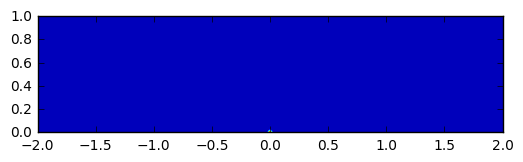

In [125]:

eij =  sqrt(0.5*(inner(sym(nabla_grad(u)), sym(nabla_grad(u)))))
eijFEM = project(eij , V1)
plot(eij , interactive=True, scalarbar = True ) 

In [126]:
File('u.pvd') << u
File('p.pvd') << p
File('eij.pvd') << eijFEM

In [615]:
# =============================================================================
# Non linear loop
# =============================================================================


# Define solution functions - current solution
w = Function(W)
u, p = split(w)


bv = (inner(sym(grad(v)), 2.*viscosity(w)*sym(grad(u))) - div(v)*p - density*inner(ez, v))
#bv = (inner(sym(grad(v)), 2.*viscosity(w)*sym(grad(u))) - div(v)*p)
bp = -q*div(u)

rv = bv*dx
rp = bp*dx
F = rv + rp

J_W = derivative(F, w)
# create nonlinear problem
problem_W = NonlinearVariationalProblem(F, w, bcs_W, J_W)
solver_W = NonlinearVariationalSolver(problem_W)
prm_W = solver_W.parameters
# Newton solver parameters (mechanical part of the problem)
prm_W["newton_solver"]["relative_tolerance"] = 1E-7
#prm_W["newton_solver"]["absolute_tolerance"] = 1E-11
prm_W["newton_solver"]["maximum_iterations"] = 10
prm_W["newton_solver"]["relaxation_parameter"] = 1.0
#prm_W["newton_solver"]["convergence_criterion"] = 'incremental'
prm_W["newton_solver"]["convergence_criterion"] = "residual"
prm_W["newton_solver"]["linear_solver"] = "mumps"
set_log_level(PROGRESS)

In [616]:
# initializing velocity-pressure from the Picard solution 
w.interpolate(current)


In [135]:
#info("Solve momentum equation")
solver_W.solve()

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2016.2.0
*** Git changeset:  0f003bc07ee5fd583fb956245016d5972b80fea1
*** -------------------------------------------------------------------------


In [136]:
# =============================================================================
# Non linear residual
# =============================================================================

b = assemble(F)    # Residual
x = w.vector()

for bc in bcs_W:
    bc.apply(b, x)
        
res_norm = b.norm('l2')

# Log output
print(res_norm)

9.34940745454e-06


In [137]:
# =============================================================================
# Figures tc
# =============================================================================

In [138]:
u, p = w.split(deepcopy=True) 

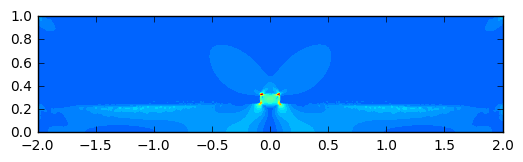

In [139]:
eij =  sqrt(0.5*(inner(sym(nabla_grad(u)), sym(nabla_grad(u)))))
eijFEM = project(eij , V1)
plot(eij , interactive=True, scalarbar = True ) 

In [140]:
File('u.pvd') << u
File('p.pvd') << p
File('eij.pvd') << eijFEM

uvals = eijFEM.vector().array()
xyvals = mesh.coordinates()
#xyvals = dofs_x
xvals = xyvals[:,0]
yvals= xyvals[:,1]

xx = np.linspace(-2,2, 100)
yy = np.linspace(0,1, 25)

XX, YY = np.meshgrid(xx,yy)


from scipy.interpolate import griddata
uu = griddata(np.column_stack((xvals, yvals)), uvals, np.dstack((XX, XX)))

uvals = eijFEM.vector().array()
xyvals = mesh.coordinates()
#xyvals = dofs_x
xvals = xyvals[:,0]
yvals= xyvals[:,1]

xx = np.linspace(-2,2, 100)
yy = np.linspace(0,1, 25)

XX, YY = np.meshgrid(xx,yy)


In [141]:
#
dolfin.fem.bcs.homogenize(bc)

AttributeError: 'module' object has no attribute 'homogenize'